# TODO

- [x] filter for weird routes (over land, non-smooth, etc.)
- [ ] Check dependency of typical best cost and typical runtime on hyperparameters

## Filtering for broken routes by length

Let's cut away routes which are more than twice as long as the seed route.

In [1]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import shapely
from matplotlib import pyplot as plt

from ship_routing.app.routing import RoutingResult

In [2]:
n_sub = None

In [3]:
result_files = sorted(Path("runs/").glob("*.json"))[:n_sub]
print(len(result_files))

15407


In [4]:
routing_results = {rf.name: RoutingResult.load_json(rf) for rf in tqdm(result_files)}
print(len(routing_results))

  0%|          | 0/15407 [00:00<?, ?it/s]

15407


In [5]:
def get_seed_member(routing_results_dict: dict = None):
    all_seed_members = {fn: rr.seed_member for fn, rr in routing_results_dict.items()}
    assert len(set(all_seed_members.values())) == 1
    return list(all_seed_members.values())[0]

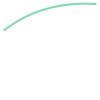

In [6]:
seed_member = get_seed_member(routing_results)
seed_member.route.line_string

In [7]:
def get_hyper_params_df(routing_results_dict: dict = None):
    df = pd.concat(
        [
            pd.DataFrame(
                rr.logs.config["hyper"],
                index=[
                    f,
                ],
            )
            for f, rr in routing_results_dict.items()
        ]
    ).add_prefix("hyper_")
    df = df.assign(
        hyper_crossover_strategy=df["hyper_crossover_strategy"].astype("category")
    )
    df.index = df.index.rename("filename")
    return df

In [8]:
df_params = get_hyper_params_df(routing_results)
df_params

,hyper_population_size,hyper_random_seed,hyper_generations,hyper_selection_quantile,hyper_selection_acceptance_rate_warmup,hyper_selection_acceptance_rate,hyper_mutation_width_fraction,hyper_mutation_displacement_fraction,hyper_mutation_iterations,hyper_crossover_strategy,hyper_crossover_rounds,hyper_num_elites,hyper_gd_iterations,hyper_learning_rate_time,hyper_learning_rate_space,hyper_time_increment,hyper_distance_increment
filename,,,,,,,,,,,,,,,,,
run_2025-12-01T19-20-37.715_143ebdb9-e807-4510-ad2a-56a167dbd738.json,16,2,2,0.5,0.3,0.1,0.9,0.1,2,random,0,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-38.102_fbae6a85-b5f8-4f75-b0d5-c7e19c211a40.json,16,5,2,0.5,0.3,0.2,0.9,0.1,2,minimal_cost,0,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-39.982_c91d8b3c-41f4-45fd-bb3c-0b871d6e8746.json,16,10,2,0.2,0.3,0.0,0.9,0.1,1,random,1,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-41.581_00280d80-028e-4518-9a10-d4f6699101d2.json,16,7,2,0.2,0.3,0.2,0.9,0.1,1,minimal_cost,0,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-42.533_ae40f686-d022-41bd-9073-176326abb3c8.json,16,0,2,0.5,0.3,0.0,0.9,0.1,3,random,1,2,2,0.5,0.5,1200.0,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_2025-12-01T21-54-26.335_5ec87bf1-64f6-4823-9df3-b3ee1543c17f.json,64,4,8,0.2,0.3,0.1,0.9,0.1,2,minimal_cost,2,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T21-54-37.019_12a6d88a-9309-4335-9bb4-1cc617800ee8.json,64,8,8,0.2,0.3,0.1,0.9,0.1,1,minimal_cost,2,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T21-58-48.567_4636969d-b0cb-4091-ac08-7f214d5e9e84.json,64,10,8,0.2,0.3,0.2,0.9,0.1,1,minimal_cost,2,2,2,0.5,0.5,1200.0,10000.0


In [9]:
def get_runtime(routing_results_dict: dict = None):
    _records = []
    for f, rr in routing_results_dict.items():
        _records.extend(
            [
                {
                    "filename": f,
                    "runtime": rr.logs.to_dataframe().timestamp.max()
                    - rr.logs.to_dataframe().timestamp.min(),
                }
            ]
        )
    df = pd.DataFrame.from_records(_records).set_index("filename")
    df = df.assign(runtime_seconds=df.runtime.dt.total_seconds())
    return df

In [10]:
df_runtime = get_runtime(routing_results)
df_runtime

/Users/wrath/scratch/ship_routing_integrated/ship_routing/src/ship_routing/app/routing.py:198: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
/Users/wrath/scratch/ship_routing_integrated/ship_routing/src/ship_routing/app/routing.py:198: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
/Users/wrath/scratch/ship_routing_integrated/ship_routing/src/ship_routing/app/routing.py:198: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to

,runtime,runtime_seconds
filename,,
run_2025-12-01T19-20-37.715_143ebdb9-e807-4510-ad2a-56a167dbd738.json,0 days 00:02:23,143.0
run_2025-12-01T19-20-38.102_fbae6a85-b5f8-4f75-b0d5-c7e19c211a40.json,0 days 00:02:23,143.0
run_2025-12-01T19-20-39.982_c91d8b3c-41f4-45fd-bb3c-0b871d6e8746.json,0 days 00:02:25,145.0
run_2025-12-01T19-20-41.581_00280d80-028e-4518-9a10-d4f6699101d2.json,0 days 00:02:26,146.0
run_2025-12-01T19-20-42.533_ae40f686-d022-41bd-9073-176326abb3c8.json,0 days 00:02:27,147.0
...,...,...
run_2025-12-01T21-54-26.335_5ec87bf1-64f6-4823-9df3-b3ee1543c17f.json,0 days 00:29:23,1763.0
run_2025-12-01T21-54-37.019_12a6d88a-9309-4335-9bb4-1cc617800ee8.json,0 days 00:33:09,1989.0
run_2025-12-01T21-58-48.567_4636969d-b0cb-4091-ac08-7f214d5e9e84.json,0 days 00:34:36,2076.0


In [11]:
def get_elite(routing_results_dict: dict = None):
    seed_member = get_seed_member(routing_results_dict)
    _records = []
    for f, rr in routing_results_dict.items():
        _records.extend(
            [
                {
                    "filename": f,
                    "n_elite": n,
                    "elite_length_meters": m.route.length_meters,
                    "elite_length_relative": m.route.length_meters / seed_member.route.length_meters,
                    "elite_cost_absolute": m.cost,
                    "elite_cost_relative": m.cost / seed_member.cost,
                }
                for n, m in enumerate(rr.elite_population.members)
            ]
        )
    return pd.DataFrame.from_records(_records).set_index("filename")

In [12]:
df_elite = get_elite(routing_results)
df_elite

,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative
filename,,,,,
run_2025-12-01T19-20-37.715_143ebdb9-e807-4510-ad2a-56a167dbd738.json,0,6.162196e+06,1.011300,1.010000e+13,0.946697
run_2025-12-01T19-20-37.715_143ebdb9-e807-4510-ad2a-56a167dbd738.json,1,6.162196e+06,1.011300,1.010000e+13,0.946697
run_2025-12-01T19-20-38.102_fbae6a85-b5f8-4f75-b0d5-c7e19c211a40.json,0,6.115479e+06,1.003633,9.916812e+12,0.929526
run_2025-12-01T19-20-38.102_fbae6a85-b5f8-4f75-b0d5-c7e19c211a40.json,1,6.115479e+06,1.003633,9.916812e+12,0.929526
run_2025-12-01T19-20-39.982_c91d8b3c-41f4-45fd-bb3c-0b871d6e8746.json,0,6.180691e+06,1.014335,9.985054e+12,0.935922
...,...,...,...,...,...
run_2025-12-01T21-58-48.567_4636969d-b0cb-4091-ac08-7f214d5e9e84.json,1,6.194878e+06,1.016663,9.537278e+12,0.893951
run_2025-12-01T21-59-14.239_279eef0c-a580-4acf-9109-47388c6eeebf.json,0,6.193325e+06,1.016408,9.549686e+12,0.895114
run_2025-12-01T21-59-14.239_279eef0c-a580-4acf-9109-47388c6eeebf.json,1,6.193325e+06,1.016408,9.549686e+12,0.895114


In [13]:
_bad_files = (
    (df_elite.reset_index().groupby("filename").elite_length_relative.max() > 1.5)
    | (df_elite.reset_index().groupby("filename").elite_cost_relative.max() > 1.1)
)
bad_filenames = _bad_files.index[_bad_files]
good_filenames = _bad_files.index[~_bad_files]
bad_filenames, good_filenames

(Index(['run_2025-12-01T19-23-01.951_bf89a22b-4565-49c0-89ac-d693197caa56.json',
        'run_2025-12-01T19-24-10.469_6391b4b0-0826-425e-a30b-b4a7bb50abea.json',
        'run_2025-12-01T19-24-40.014_4283cce3-c44d-4d48-b462-5b74d23b92ef.json',
        'run_2025-12-01T19-24-46.095_a62c9e69-bb53-496e-9f49-b6cdf1e8f82e.json',
        'run_2025-12-01T19-25-13.446_0aabc42c-2bd1-4b3f-843c-b8ef398fadd3.json',
        'run_2025-12-01T19-25-43.228_5d4c7351-52d9-4c5e-bea2-23a4e423dc0e.json',
        'run_2025-12-01T19-25-53.338_56b69f61-577a-4b20-a99a-c5829af17e35.json',
        'run_2025-12-01T19-25-54.717_a03756de-3c07-4294-9ccb-095f59ef9750.json',
        'run_2025-12-01T19-26-03.476_db57c3a1-a9e0-4d74-b863-62c0e18ee0f1.json',
        'run_2025-12-01T19-27-59.302_f8c2c682-4b37-461e-9d93-56752921c333.json',
        ...
        'run_2025-12-01T21-37-56.421_74fc1690-dfb7-43fa-8dd9-d098c258d6a2.json',
        'run_2025-12-01T21-38-00.603_16e76a9b-a7fc-4144-abc1-c754fb6128cd.json',
        'run_202

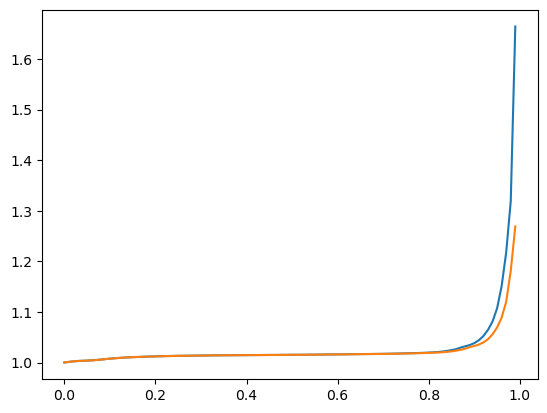

In [14]:
ax = df_elite.elite_length_relative.quantile(np.arange(0, 1, 0.01)).plot(logy=False, grid=True);
df_elite.loc[good_filenames].elite_length_relative.quantile(np.arange(0, 1, 0.01)).plot(logy=False, ax=ax);

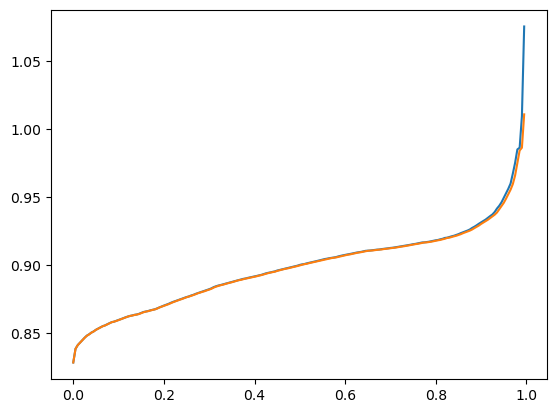

In [15]:
ax = df_elite.elite_cost_relative.quantile(np.arange(0, 1, 0.005)).plot(logy=False, grid=True);
df_elite.loc[good_filenames].elite_cost_relative.quantile(np.arange(0, 1, 0.005)).plot(logy=False, ax=ax);

In [16]:
df_merged = (
    df_params
    .merge(df_elite, left_index=True, right_index=True, how="inner")
    .merge(df_runtime, left_index=True, right_index=True, how="inner")
)
df_merged = df_merged.loc[good_filenames]
df_merged

,hyper_population_size,hyper_random_seed,hyper_generations,hyper_selection_quantile,hyper_selection_acceptance_rate_warmup,hyper_selection_acceptance_rate,hyper_mutation_width_fraction,hyper_mutation_displacement_fraction,hyper_mutation_iterations,hyper_crossover_strategy,...,hyper_learning_rate_space,hyper_time_increment,hyper_distance_increment,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative,runtime,runtime_seconds
filename,,,,,,,,,,,,,,,,,,,,,
run_2025-12-01T19-20-37.715_143ebdb9-e807-4510-ad2a-56a167dbd738.json,16,2,2,0.5,0.3,0.1,0.9,0.1,2,random,...,0.5,1200.0,10000.0,0,6.162196e+06,1.011300,1.010000e+13,0.946697,0 days 00:02:23,143.0
run_2025-12-01T19-20-37.715_143ebdb9-e807-4510-ad2a-56a167dbd738.json,16,2,2,0.5,0.3,0.1,0.9,0.1,2,random,...,0.5,1200.0,10000.0,1,6.162196e+06,1.011300,1.010000e+13,0.946697,0 days 00:02:23,143.0
run_2025-12-01T19-20-38.102_fbae6a85-b5f8-4f75-b0d5-c7e19c211a40.json,16,5,2,0.5,0.3,0.2,0.9,0.1,2,minimal_cost,...,0.5,1200.0,10000.0,0,6.115479e+06,1.003633,9.916812e+12,0.929526,0 days 00:02:23,143.0
run_2025-12-01T19-20-38.102_fbae6a85-b5f8-4f75-b0d5-c7e19c211a40.json,16,5,2,0.5,0.3,0.2,0.9,0.1,2,minimal_cost,...,0.5,1200.0,10000.0,1,6.115479e+06,1.003633,9.916812e+12,0.929526,0 days 00:02:23,143.0
run_2025-12-01T19-20-39.982_c91d8b3c-41f4-45fd-bb3c-0b871d6e8746.json,16,10,2,0.2,0.3,0.0,0.9,0.1,1,random,...,0.5,1200.0,10000.0,0,6.180691e+06,1.014335,9.985054e+12,0.935922,0 days 00:02:25,145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_2025-12-01T21-58-48.567_4636969d-b0cb-4091-ac08-7f214d5e9e84.json,64,10,8,0.2,0.3,0.2,0.9,0.1,1,minimal_cost,...,0.5,1200.0,10000.0,1,6.194878e+06,1.016663,9.537278e+12,0.893951,0 days 00:34:36,2076.0
run_2025-12-01T21-59-14.239_279eef0c-a580-4acf-9109-47388c6eeebf.json,64,6,8,0.2,0.3,0.1,0.9,0.1,1,minimal_cost,...,0.5,1200.0,10000.0,0,6.193325e+06,1.016408,9.549686e+12,0.895114,0 days 00:34:25,2065.0
run_2025-12-01T21-59-14.239_279eef0c-a580-4acf-9109-47388c6eeebf.json,64,6,8,0.2,0.3,0.1,0.9,0.1,1,minimal_cost,...,0.5,1200.0,10000.0,1,6.193325e+06,1.016408,9.549686e+12,0.895114,0 days 00:34:25,2065.0


In [17]:
df_merged.columns

Index(['hyper_population_size', 'hyper_random_seed', 'hyper_generations',
       'hyper_selection_quantile', 'hyper_selection_acceptance_rate_warmup',
       'hyper_selection_acceptance_rate', 'hyper_mutation_width_fraction',
       'hyper_mutation_displacement_fraction', 'hyper_mutation_iterations',
       'hyper_crossover_strategy', 'hyper_crossover_rounds',
       'hyper_num_elites', 'hyper_gd_iterations', 'hyper_learning_rate_time',
       'hyper_learning_rate_space', 'hyper_time_increment',
       'hyper_distance_increment', 'n_elite', 'elite_length_meters',
       'elite_length_relative', 'elite_cost_absolute', 'elite_cost_relative',
       'runtime', 'runtime_seconds'],
      dtype='object')

In [18]:
df_analysis = (
  df_merged
  .groupby(level=0)  # group by filename
  .agg({
      'elite_cost_relative': 'min',  # best cost
      'elite_length_relative': 'min',  # best cost
      'runtime': 'first',  # same for all rows
      **{col: 'first' for col in df_merged.columns if col.startswith('hyper_')}
  })
)
df_analysis

,elite_cost_relative,elite_length_relative,runtime,hyper_population_size,hyper_random_seed,hyper_generations,hyper_selection_quantile,hyper_selection_acceptance_rate_warmup,hyper_selection_acceptance_rate,hyper_mutation_width_fraction,hyper_mutation_displacement_fraction,hyper_mutation_iterations,hyper_crossover_strategy,hyper_crossover_rounds,hyper_num_elites,hyper_gd_iterations,hyper_learning_rate_time,hyper_learning_rate_space,hyper_time_increment,hyper_distance_increment
filename,,,,,,,,,,,,,,,,,,,,
run_2025-12-01T19-20-37.715_143ebdb9-e807-4510-ad2a-56a167dbd738.json,0.946697,1.011300,0 days 00:02:23,16,2,2,0.5,0.3,0.1,0.9,0.1,2,random,0,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-38.102_fbae6a85-b5f8-4f75-b0d5-c7e19c211a40.json,0.929526,1.003633,0 days 00:02:23,16,5,2,0.5,0.3,0.2,0.9,0.1,2,minimal_cost,0,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-39.982_c91d8b3c-41f4-45fd-bb3c-0b871d6e8746.json,0.935922,1.014335,0 days 00:02:25,16,10,2,0.2,0.3,0.0,0.9,0.1,1,random,1,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-41.581_00280d80-028e-4518-9a10-d4f6699101d2.json,0.935605,1.012759,0 days 00:02:26,16,7,2,0.2,0.3,0.2,0.9,0.1,1,minimal_cost,0,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T19-20-42.533_ae40f686-d022-41bd-9073-176326abb3c8.json,0.897849,1.020319,0 days 00:02:27,16,0,2,0.5,0.3,0.0,0.9,0.1,3,random,1,2,2,0.5,0.5,1200.0,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_2025-12-01T21-54-26.335_5ec87bf1-64f6-4823-9df3-b3ee1543c17f.json,0.905199,1.014957,0 days 00:29:23,64,4,8,0.2,0.3,0.1,0.9,0.1,2,minimal_cost,2,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T21-54-37.019_12a6d88a-9309-4335-9bb4-1cc617800ee8.json,0.875525,1.014660,0 days 00:33:09,64,8,8,0.2,0.3,0.1,0.9,0.1,1,minimal_cost,2,2,2,0.5,0.5,1200.0,10000.0
run_2025-12-01T21-58-48.567_4636969d-b0cb-4091-ac08-7f214d5e9e84.json,0.893951,1.016663,0 days 00:34:36,64,10,8,0.2,0.3,0.2,0.9,0.1,1,minimal_cost,2,2,2,0.5,0.5,1200.0,10000.0


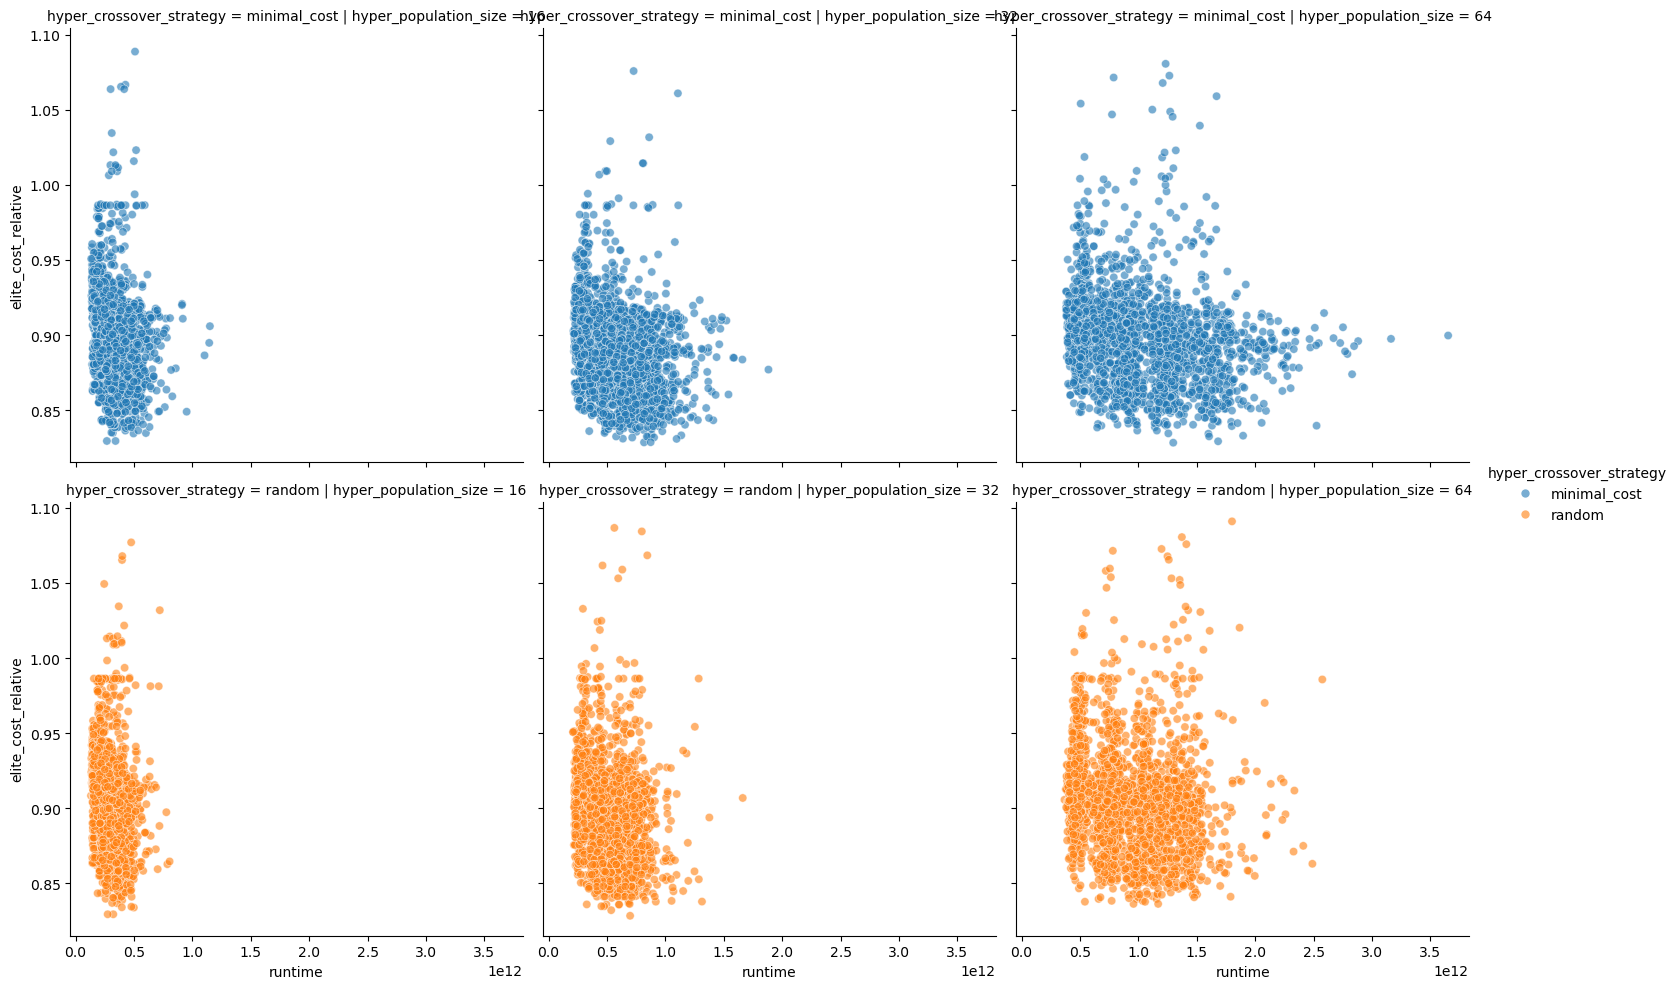

In [19]:
sns.relplot(
    data=df_analysis,
    x='runtime',
    y='elite_cost_relative',
    hue='hyper_crossover_strategy',
    col='hyper_population_size',
    row="hyper_crossover_strategy",
    alpha=0.6
)

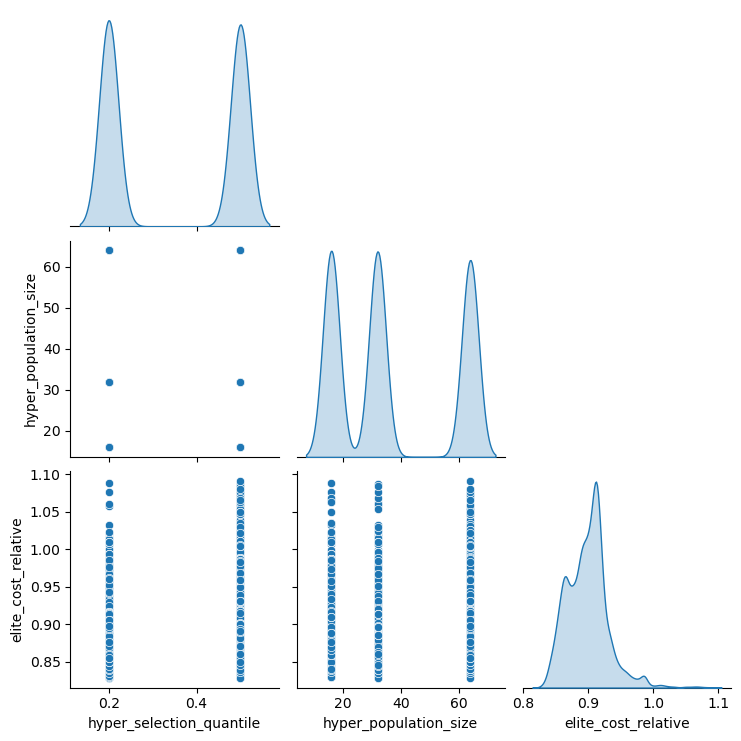

In [20]:
# Select key hyperparameters
key_vars = [
  'hyper_selection_quantile',
  'hyper_population_size',
  'elite_cost_relative',
  'runtime'
]
sns.pairplot(df_analysis[key_vars], diag_kind='kde', corner=True)

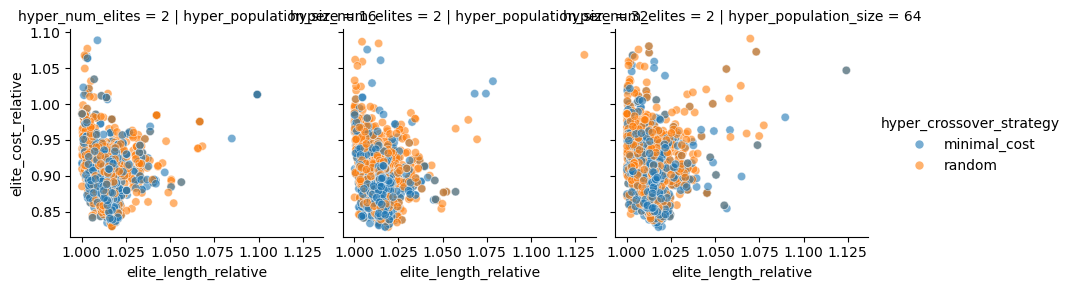

In [21]:
 sns.relplot(
      data=df_analysis,
      x='elite_length_relative',
      y='elite_cost_relative',
      hue='hyper_crossover_strategy',
      col='hyper_population_size',
      row='hyper_num_elites',
      kind='scatter',
      alpha=0.6,
      height=3
  )

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_29805/122762472.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])


<Axes: xlabel='hyper_population_size', ylabel='hyper_generations-hyper_crossover_strategy'>

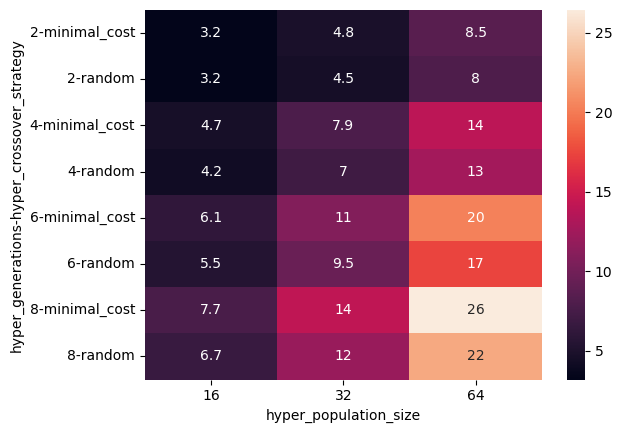

In [22]:
sns.heatmap(
    df_merged
    .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])
    .runtime
    .median()
    .dt.total_seconds()
    .unstack(0) / 60,
    annot=True
)

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_29805/73672402.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])


<Axes: xlabel='hyper_population_size', ylabel='hyper_generations-hyper_crossover_strategy'>

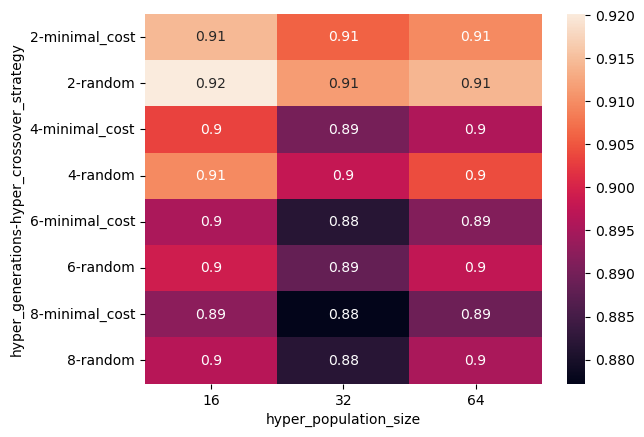

In [23]:
sns.heatmap(
    df_merged
    .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])
    .elite_cost_relative
    .median()
    .unstack(0),
    annot=True
)